In [5]:
from keras.applications import resnet50
from PIL import Image
from keras.preprocessing import image
import numpy as np
import pandas as pd
import warnings
import cv2
from cv2 import imread
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt

In [6]:
def plot_loss_acc(values,model_name='Model'):
    labels = ['loss','accuracy']
    colors = ['#1f77b4', '#2ca02c']
    plt.figure(figsize=(5,1.2))
    plt.table(cellText=[[labels[0],"{:.4f}".format(values[0])], [labels[1], "{:.2%}".format(values[1])]],
            colWidths=[0.8, 0.8],
            cellLoc='center',
            loc='center',
            cellColours=[['lightgrey', colors[0]], ['lightgrey', colors[1]]])
    plt.title(model_name+' Loss and Accuracy',y=0.7)
    plt.axis('off')
    plt.tight_layout() 

def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('Cross Entropy Loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('Accuracy')
    ax.grid(True)

def display_roc(roc_auc , fpr, tpr, class_num, model_name=''):
    plt.figure(figsize=(10, 6))
    for i in range(class_num):
        plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class {}) (AUC = {:.2f})'.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')                                                                                                                   
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve of {}'.format(model_name))
    plt.legend(loc="lower right")
    plt.show()

def plot_multiclass_roc(model, x_test, y_test, class_num, model_name='', show=True):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    y_test = keras.utils.to_categorical(y_test, class_num)


    y_pred = model.predict(x_test).astype('float32')
    print(y_test.shape)
    print(y_pred.shape)
    for i in range(class_num):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_pred[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    if show:    display_roc(roc_auc,fpr,tpr,class_num,model_name)
    else: return roc_auc

In [1]:
from keras.applications import ResNet50V2

resnet50_model = ResNet50V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)
resnet50_model.summary()




102869336/102869336 [==============================] - 23s 0us/step
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                  

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.regularizers import l2

l2_weight = 0.0001

model_vgg16 = Sequential(name='VGG16')

# Input
model_vgg16.add(Input(shape=(224, 224, 3)))  # Assuming input shape of (224, 224, 3)

# Block 1
model_vgg16.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model_vgg16.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(128, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model_vgg16.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(256, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Conv2D(512, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Flatten
model_vgg16.add(Flatten())

# Fully connected layers
model_vgg16.add(Dense(4096, activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dense(4096, activation='relu', kernel_regularizer=l2(l2_weight)))
model_vgg16.add(BatchNormalization())
model_vgg16.add(Dense(1000, activation='softmax'))  # Assuming 1000 classes

# Display summary
model_vgg16.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 batch_normalization_12 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 conv2d_11 (Conv2D)          (None, 224, 224, 64)      36928     
                                                                 
 batch_normalization_13 (Ba  (None, 224, 224, 64)      256       
 tchNormalization)                                               
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                             

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1, 
    restore_best_weights=True)

model_checkpoint = ModelCheckpoint(
    filepath='model12.keras', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.8, 
    patience=2, 
    min_lr=0.00001)

batch_size = 64
epoch = 80
opt = Adam(learning_rate=0.0004)

model_vgg16.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
start = time()
history_vgg = model_vgg16.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epoch,
              validation_data=(x_test, y_test),
              callbacks=[early_stopping, model_checkpoint, reduce_lr])
vgg_time = time() - start
saved_model12 = load_model('vgg_xray.keras')
plot_loss_accuracy(history_vgg)

In [7]:
df = pd.read_csv('sample_labels.csv')
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [10]:
df['Finding Labels'].value_counts()

Finding Labels
No Finding                                                3044
Infiltration                                               503
Effusion                                                   203
Atelectasis                                                192
Nodule                                                     144
                                                          ... 
Atelectasis|Edema|Effusion|Infiltration|Pneumonia            1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia       1
Atelectasis|Effusion|Hernia                                  1
Atelectasis|Hernia|Pneumothorax                              1
Cardiomegaly|Effusion|Emphysema                              1
Name: count, Length: 244, dtype: int64

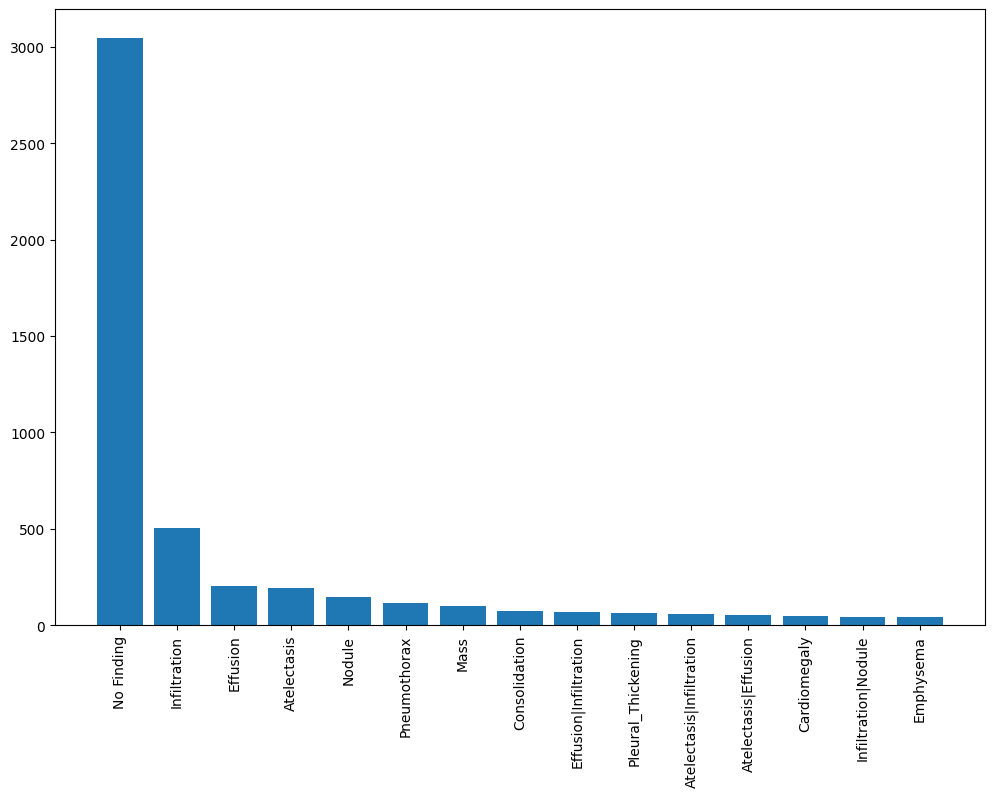

In [11]:
label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [12]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
5460,00029721_000.png,,0,29721,056Y,F,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5056,00026843_001.png,Effusion|Mass,1,26843,058Y,F,AP,3056,2544,0.139000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2194,00011355_018.png,,18,11355,035Y,M,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
cases = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
df['Atelectasis'].value_counts()

Atelectasis
0.0    5098
1.0     508
Name: count, dtype: int64

In [17]:
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(df[c_label].sum())) for c_label in all_labels])

Clean Labels (0) []
